# Party-Press Alignmnet

In this script we use a correlation function to calculate the alignment in salience between political communication and media coverage. We then investigate the results by visualising the associations. 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib.ticker import MultipleLocator
from itertools import permutations
from scipy.signal import correlate
import numpy as np
import seaborn as sns

## Initialise

In [166]:
df = pd.read_csv('/.../4_media_and_party_salience_BY_CLASS_across_time_counts_.csv')

In [167]:
leanings = ['left','centre-left','centre','centre-right','right']

In [168]:
colors = {'left':'red',
         'centre-left':'lightsalmon',
         'centre':'blue',
         'centre-right':'lightseagreen',#'darkcyan',#lightseagreen
         'right': 'black'}

## Calculate Correlation

In [169]:
all_permutations = []
for element in leanings:
    all_permutations.append((element, element))
all_permutations.extend(list(permutations(leanings, 2)))

In [171]:
alignment_df = pd.DataFrame(columns=[
       'time_period', 'start_date', 'end_date', 'media_leaning',
       'party_leaning', 'imm_alignment','clim_alignment',
       'imm_media_salience', 'clim_media_salience',
       'imm_party_salience', 'clim_party_salience'
])

for pair in all_permutations:
    time_df = pd.read_csv('/Users/giovanni/masterthesis/7_Salience_monthly/general_time_periods_df.csv')
    time_df['media_leaning'] = pair[0]
    time_df['party_leaning'] = pair[1]
    
    time_df['imm_alignment'] = None
    time_df['clim_alignment'] = None
    
    time_df['imm_media_salience'] = df[f'imm_salience_media_{pair[0]}']
    time_df['clim_media_salience'] = df[f'clim_salience_media_{pair[0]}']
    
    time_df['imm_party_salience'] = df[f'imm_salience_party_{pair[1]}']
    time_df['clim_party_salience'] = df[f'clim_salience_party_{pair[1]}']
    
    for index in df.index:
        time_df.loc[index,'imm_alignment'] = correlate(df.loc[index,f'imm_salience_media_{pair[0]}'], df.loc[index,f'imm_salience_party_{pair[1]}'])
        time_df.loc[index,'clim_alignment'] = correlate(df.loc[index,f'clim_salience_media_{pair[0]}'], df.loc[index,f'clim_salience_party_{pair[1]}'])
    
    alignment_df = pd.concat([alignment_df,time_df], ignore_index = True)

In [83]:
alignment_df.to_csv('/.../5_media_party_class_salience_CORRELATION_across_time.csv', index = False)

# Plotting

In [4]:
plot_df = alignment_df.copy()
plot_df = plot_df.set_index('start_date')

In [5]:
def plot_alignment(plot_df, columns, media_leaning, party_leaning):
    fig, ax1 = plt.subplots(figsize=(10, 4))
    
    temp_df = plot_df[plot_df['media_leaning'] == media_leaning]
    temp_df = temp_df[temp_df['party_leaning'] == party_leaning]
    
    ax1.plot(temp_df[f'{columns[0]}_alignment'], linestyle='-', color='black', label=columns[0])
    if len(columns) > 1:
        ax1.plot(temp_df[f'{columns[1]}_alignment'], linestyle='-', color='green', label=columns[1])

    ax1.set_xlabel('Date')
    ax1.set_ylabel('Salience Alignment')
    ax1.tick_params(axis='y')
    ax1.set_ylim(0, 0.012)
    ax1.grid(True)

    fig.legend(loc='right', bbox_to_anchor=(1.05, 0.5))
    plt.setp(ax1.get_xticklabels(), rotation=90)
    plt.title(f'Alignment of salience $\mathbf{{{party_leaning}}}$ parties and $\mathbf{{{media_leaning}}}$ media')
    ax1.xaxis.set_major_locator(MultipleLocator(4))
    plt.show()


In [16]:
plot_df['end_date'] = pd.to_datetime(plot_df['end_date'])

plot_df['media_leaning'] = pd.Categorical(plot_df['media_leaning'], categories=leanings, ordered=True)
plot_df['party_leaning'] = pd.Categorical(plot_df['party_leaning'], categories=leanings, ordered=True)

imm_df = pd.DataFrame(plot_df.groupby(['media_leaning', 'party_leaning'])['imm_alignment'].mean()).reset_index()
imm_df = imm_df.sort_values(by=['media_leaning', 'party_leaning'])

clim_df = pd.DataFrame(plot_df.groupby(['media_leaning', 'party_leaning'])['clim_alignment'].mean()).reset_index()
clim_df = clim_df.sort_values(by=['media_leaning', 'party_leaning'])

In [63]:
pd.DataFrame(plot_df.groupby(['media_leaning', 'party_leaning','end_date'])['imm_alignment'].mean()).reset_index()

,media_leaning,party_leaning,end_date,imm_alignment
0,left,left,2017-01-31,0.000168
1,left,left,2017-03-02,0.000030
2,left,left,2017-04-01,0.000047
3,left,left,2017-05-01,0.000026
4,left,left,2017-05-31,0.000013
...,...,...,...,...
795,right,right,2019-04-21,0.001587
796,right,right,2019-05-21,0.001616
797,right,right,2019-06-20,0.001134
798,right,right,2019-07-20,0.002020


In [97]:
def plot_same_side_alignment(debate, max_y):
    fig, ax1 = plt.subplots(figsize=(10, 4))
    
    temp = plot_df[plot_df['media_leaning'] == plot_df['party_leaning']]
    temp['start_date'] = pd.to_datetime(temp['start_date'])
    temp = temp.set_index('start_date')
    
    if debate == 'immigration':
        for media_leaning in list(temp['media_leaning'].unique()):
            temp_temp_df = temp[temp['media_leaning'] == media_leaning]
            ax1.plot(temp_temp_df['imm_alignment'], linestyle='-', 
                     color=colors.get(media_leaning, 'black'), label=media_leaning)
            
            ax1.axvline(x=pd.to_datetime('2018-12-19'), color='black', linestyle=':', linewidth=2)
            ax1.text(pd.to_datetime('2018-12-19'), max_y * 0.5, ' Marrakech Pact', verticalalignment='bottom', color='black', fontweight='light')
            ax1.axvline(x=pd.to_datetime('2018-08-01'), color='black', linestyle=':', linewidth=2)
            ax1.text(pd.to_datetime('2018-08-01'), max_y * 0.85, ' Immigration law passed', verticalalignment='bottom', color='black', fontweight='light')
            ax1.axvline(x=pd.to_datetime('2018-04-20'), color='black', linestyle=':', linewidth=2)
            ax1.text(pd.to_datetime('2018-04-20'), max_y * 0.94, ' Immigration law 1st reading', verticalalignment='bottom', color='black', fontweight='light')
    
    if debate == 'climate':
        for media_leaning in list(temp['media_leaning'].unique()):
            temp_temp_df = temp[temp['media_leaning'] == media_leaning]
            ax1.plot(temp_temp_df['clim_alignment'], linestyle='-', 
                     color=colors.get(media_leaning, 'black'), label=media_leaning)
            
            ax1.axvline(x=pd.to_datetime('2017-11-17'), color='g', linestyle=':', linewidth=2)
            ax1.text(pd.to_datetime('2017-11-17'), max_y * 0.9, ' COP 2017', verticalalignment='bottom', color='g', fontweight='light')
            ax1.axvline(x=pd.to_datetime('2018-12-14'), color='g', linestyle=':', linewidth=2)
            ax1.text(pd.to_datetime('2018-12-14'), max_y * 0.9, ' COP 2018', verticalalignment='bottom', color='g', fontweight='light')

            ax1.axvspan(pd.to_datetime('2019-01-15'), pd.to_datetime('2019-05-24'), color='g', alpha=0.05)
            interval_start = pd.to_datetime('2019-01-15')
            interval_end = pd.to_datetime('2019-05-24')
            interval_label = 'Youth for climate'  # Customize the label as per your requirement
            interval_center = interval_start + (interval_end - interval_start) / 2
            ax1.text(interval_center, max_y * 1.01, interval_label, horizontalalignment='center', color='g', fontweight='light')

            ax1.axvline(x=pd.to_datetime('2018-08-04'), color='g', linestyle=':', linewidth=2)
            ax1.text(pd.to_datetime('2018-08-04'), max_y * 0.7, ' 2018 heat wave', verticalalignment='bottom', color='g', fontweight='light')
            ax1.axvline(x=pd.to_datetime('2018-10-17'), color='g', linestyle=':', linewidth=2)
            ax1.text(pd.to_datetime('2018-10-17'), max_y * 0.8, ' Yellow vests', verticalalignment='bottom', color='g', fontweight='light')

    
    
    
    ax1.axvline(x=pd.to_datetime('2017-05-07'), color='r', linestyle=':', linewidth=2)
    ax1.text(pd.to_datetime('2017-05-07'), max_y * 0.8, ' 2017 presidential election', verticalalignment='bottom', color='r', fontweight='light')
    
    ax1.axvline(x=pd.to_datetime('2019-05-26'), color='r', linestyle=':', linewidth=2)
    ax1.text(pd.to_datetime('2019-05-26'), max_y * 0.8, ' 2019 EU election', verticalalignment='bottom', color='r', fontweight='light')

    
    

    ax1.set_xlabel('Date')
    ax1.set_ylabel('Salience Alignment')
    ax1.tick_params(axis='y')
    ax1.set_ylim(0, 0.012)
    ax1.grid(True)

    fig.legend(loc='right', bbox_to_anchor=(1.05, 0.5))
    plt.setp(ax1.get_xticklabels(), rotation=90)
    plt.title(f'{debate.capitalize()} debate')
    plt.show()

In [70]:
plot_df.columns

Index(['time_period', 'start_date', 'end_date', 'media_leaning',
       'party_leaning', 'imm_alignment', 'clim_alignment',
       'imm_media_salience', 'clim_media_salience', 'imm_party_salience',
       'clim_party_salience'],
      dtype='object')

/var/folders/zb/cxb4bvjs4x73pskfrpb9cpg40000gn/T/ipykernel_18090/2706078682.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['start_date'] = pd.to_datetime(temp['start_date'])


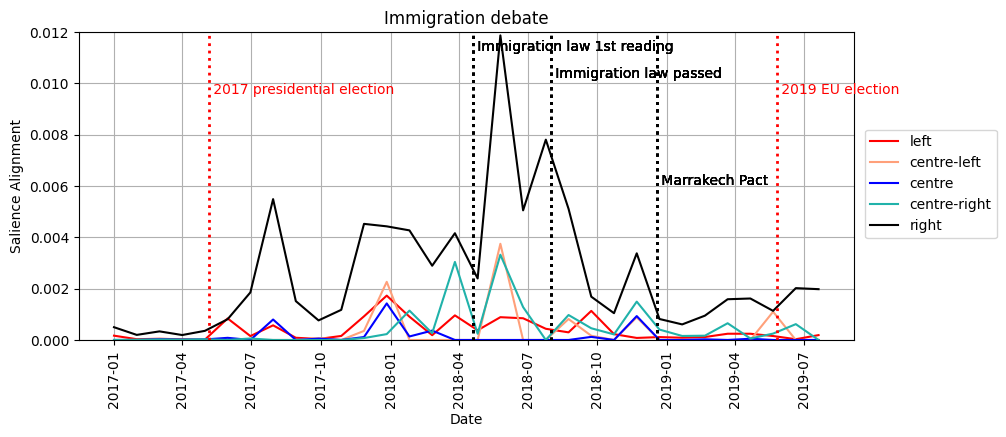

In [98]:
plot_same_side_alignment('immigration', max(plot_df.imm_alignment))

/var/folders/zb/cxb4bvjs4x73pskfrpb9cpg40000gn/T/ipykernel_18090/2706078682.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['start_date'] = pd.to_datetime(temp['start_date'])


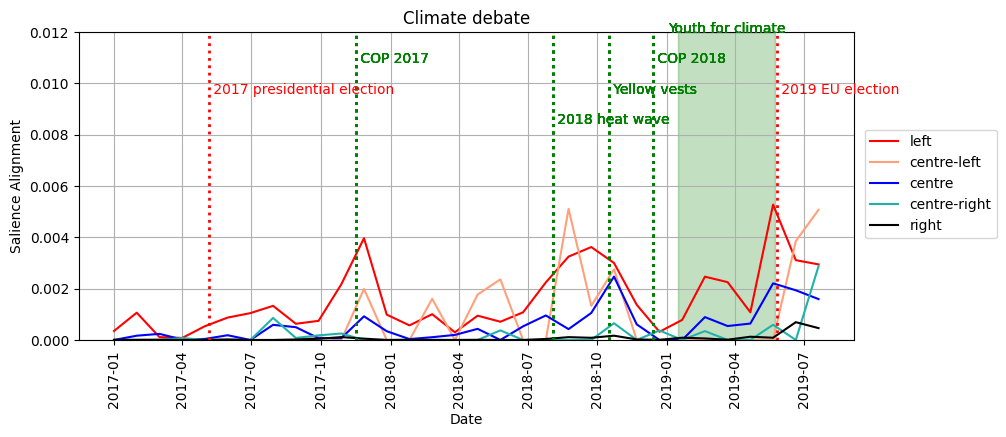

In [99]:
plot_same_side_alignment('climate', max(plot_df.imm_alignment))

In [153]:
for leaning in leanings: 
    centre = 'centre'
    
    if 'left' in leaning: 
        opposite = 'right|centre-right'
    elif 'right' in leaning: 
        opposite = 'left|centre-left'
    else: 
        continue
    
    temp = plot_df[(plot_df['media_leaning'] == leaning) & (plot_df['party_leaning'].str.contains(opposite))]
    temp['start_date'] = pd.to_datetime(temp['start_date'])
    temp = temp.groupby('start_date').agg({'imm_alignment': 'mean'})
    print(leaning)
    
    print(centre, opposite)

left
centre right|centre-right
centre-left
centre right|centre-right
centre-right
centre left|centre-left
right
centre left|centre-left


/var/folders/zb/cxb4bvjs4x73pskfrpb9cpg40000gn/T/ipykernel_18090/988750394.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['start_date'] = pd.to_datetime(temp['start_date'])
/var/folders/zb/cxb4bvjs4x73pskfrpb9cpg40000gn/T/ipykernel_18090/988750394.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['start_date'] = pd.to_datetime(temp['start_date'])
/var/folders/zb/cxb4bvjs4x73pskfrpb9cpg40000gn/T/ipykernel_18090/988750394.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy

In [159]:
def plot_opposite_side_alignment(debate, max_y):
    fig, ax1 = plt.subplots(figsize=(10, 4))
    
    for leaning in leanings: 
        centre = 'centre'

        if 'left' in leaning: 
            opposite = 'right|centre-right'
        elif 'right' in leaning: 
            opposite = 'left|centre-left'
        else: 
            continue

        temp = plot_df[(plot_df['media_leaning'] == leaning) & (plot_df['party_leaning'].str.contains(opposite))]

        temp['start_date'] = pd.to_datetime(temp['start_date'])
        temp = temp.set_index('start_date')
    
        if debate == 'immigration':
            temp = temp.groupby('start_date').agg({'imm_alignment': 'mean'})
            
            ax1.plot(temp['imm_alignment'], linestyle='-', 
                     color=colors.get(leaning, 'black'), label=f'{leaning}-opposite')
            
            ax1.axvline(x=pd.to_datetime('2018-12-19'), color='black', linestyle=':', linewidth=2)
            ax1.text(pd.to_datetime('2018-12-19'), max_y * 0.5, ' Marrakech Pact', verticalalignment='bottom', color='black', fontweight='light')
            ax1.axvline(x=pd.to_datetime('2018-08-01'), color='black', linestyle=':', linewidth=2)
            ax1.text(pd.to_datetime('2018-08-01'), max_y * 0.85, ' Immigration law passed', verticalalignment='bottom', color='black', fontweight='light')
            ax1.axvline(x=pd.to_datetime('2018-04-20'), color='black', linestyle=':', linewidth=2)
            ax1.text(pd.to_datetime('2018-04-20'), max_y * 0.94, ' Immigration law 1st reading', verticalalignment='bottom', color='black', fontweight='light')
    
        if debate == 'climate':
            temp = temp.groupby('start_date').agg({'clim_alignment': 'mean'})
            ax1.plot(temp['clim_alignment'], linestyle='-', 
                     color=colors.get(leaning, 'black'), label=f'{leaning}-opposite')
            
            ax1.axvline(x=pd.to_datetime('2017-11-17'), color='g', linestyle=':', linewidth=2)
            ax1.text(pd.to_datetime('2017-11-17'), max_y * 0.9, ' COP 2017', verticalalignment='bottom', color='g', fontweight='light')
            ax1.axvline(x=pd.to_datetime('2018-12-14'), color='g', linestyle=':', linewidth=2)
            ax1.text(pd.to_datetime('2018-12-14'), max_y * 0.9, ' COP 2018', verticalalignment='bottom', color='g', fontweight='light')

            ax1.axvspan(pd.to_datetime('2019-01-15'), pd.to_datetime('2019-05-24'), color='g', alpha=0.05)
            interval_start = pd.to_datetime('2019-01-15')
            interval_end = pd.to_datetime('2019-05-24')
            interval_label = 'Youth for climate'  # Customize the label as per your requirement
            interval_center = interval_start + (interval_end - interval_start) / 2
            ax1.text(interval_center, max_y * 1.01, interval_label, horizontalalignment='center', color='g', fontweight='light')

            ax1.axvline(x=pd.to_datetime('2018-08-04'), color='g', linestyle=':', linewidth=2)
            ax1.text(pd.to_datetime('2018-08-04'), max_y * 0.7, ' 2018 heat wave', verticalalignment='bottom', color='g', fontweight='light')
            ax1.axvline(x=pd.to_datetime('2018-10-17'), color='g', linestyle=':', linewidth=2)
            ax1.text(pd.to_datetime('2018-10-17'), max_y * 0.8, ' Yellow vests', verticalalignment='bottom', color='g', fontweight='light')

    
    
    
    ax1.axvline(x=pd.to_datetime('2017-05-07'), color='r', linestyle=':', linewidth=2)
    ax1.text(pd.to_datetime('2017-05-07'), max_y * 0.8, ' 2017 presidential election', verticalalignment='bottom', color='r', fontweight='light')
    
    ax1.axvline(x=pd.to_datetime('2019-05-26'), color='r', linestyle=':', linewidth=2)
    ax1.text(pd.to_datetime('2019-05-26'), max_y * 0.8, ' 2019 EU election', verticalalignment='bottom', color='r', fontweight='light')

    
    

    ax1.set_xlabel('Date')
    ax1.set_ylabel('Salience Alignment')
    ax1.tick_params(axis='y')
    ax1.set_ylim(0, max_y)
    ax1.grid(True)

    fig.legend(loc='right', bbox_to_anchor=(1.05, 0.5))
    plt.setp(ax1.get_xticklabels(), rotation=90)
    plt.title(f'{debate.capitalize()} debate')
    plt.show()

/var/folders/zb/cxb4bvjs4x73pskfrpb9cpg40000gn/T/ipykernel_18090/1635872026.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['start_date'] = pd.to_datetime(temp['start_date'])
/var/folders/zb/cxb4bvjs4x73pskfrpb9cpg40000gn/T/ipykernel_18090/1635872026.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['start_date'] = pd.to_datetime(temp['start_date'])
/var/folders/zb/cxb4bvjs4x73pskfrpb9cpg40000gn/T/ipykernel_18090/1635872026.py:16: SettingWithCopyWarning: 
A value is trying to be set on a c

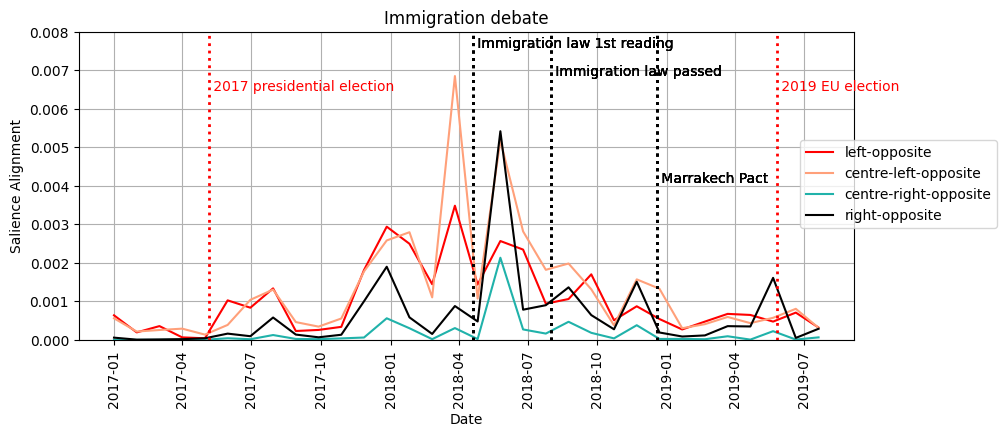

In [160]:
plot_opposite_side_alignment('immigration', 0.008)

/var/folders/zb/cxb4bvjs4x73pskfrpb9cpg40000gn/T/ipykernel_18090/1635872026.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['start_date'] = pd.to_datetime(temp['start_date'])
/var/folders/zb/cxb4bvjs4x73pskfrpb9cpg40000gn/T/ipykernel_18090/1635872026.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['start_date'] = pd.to_datetime(temp['start_date'])
/var/folders/zb/cxb4bvjs4x73pskfrpb9cpg40000gn/T/ipykernel_18090/1635872026.py:16: SettingWithCopyWarning: 
A value is trying to be set on a c

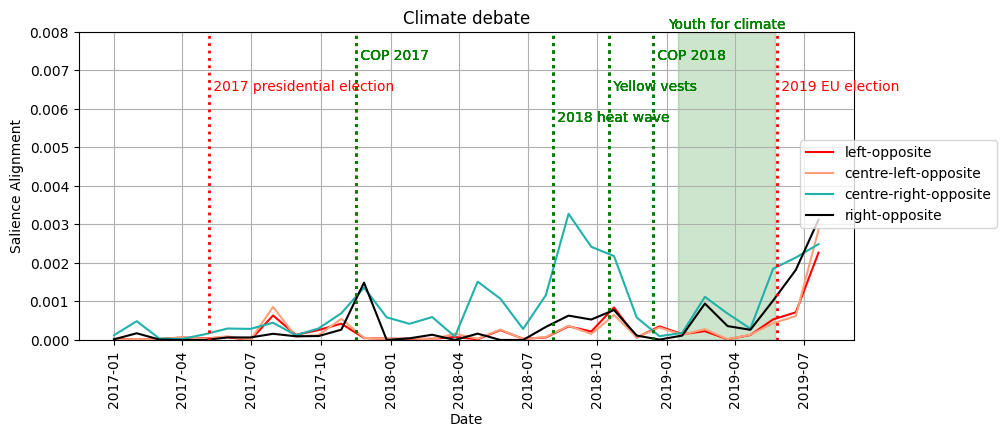

In [161]:
plot_opposite_side_alignment('climate', 0.008)

## HEATMAPS

In [59]:
min_val = 0
max_val = 0.055

General Heatmaps

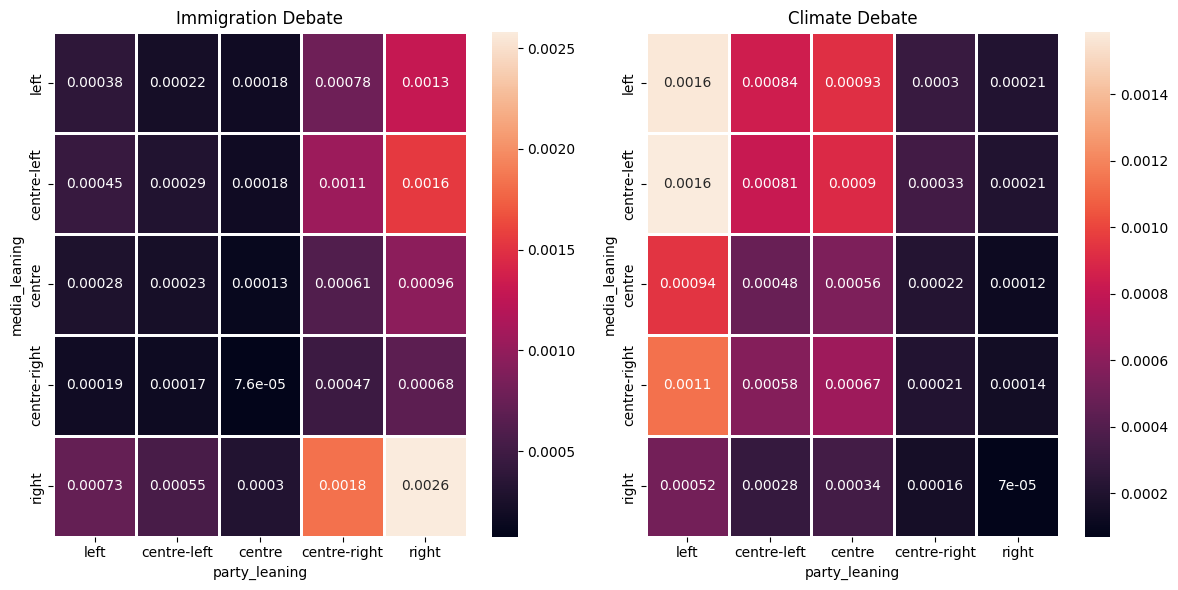

In [107]:
dataframes = [imm_df, clim_df]
names = ['immigration','climate']

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for df, name, ax in zip(dataframes, names, axes.flatten()):
    
    if name == 'immigration':
        plot = pd.crosstab(index=imm_df['media_leaning'], columns=imm_df['party_leaning'], values=imm_df['imm_alignment'], aggfunc='mean')
    
    if name == 'climate':
        plot = pd.crosstab(index=clim_df['media_leaning'], columns=clim_df['party_leaning'], values=clim_df['clim_alignment'], aggfunc='mean')
    
    sns.heatmap(plot, annot=True, ax=ax,linewidth=.8)
    ax.set_title(f'{name.capitalize()} Debate')
    
plt.tight_layout()
plt.show()

Specific periods heatmaps: yearly, elections, and moments of high salience

In [112]:
imm = pd.DataFrame(plot_df.groupby(['media_leaning', 'party_leaning','end_date'])['imm_alignment'].mean()).reset_index()
clim = pd.DataFrame(plot_df.groupby(['media_leaning', 'party_leaning','end_date'])['clim_alignment'].mean()).reset_index()

imm2017 = imm[imm['end_date'] < '2018-01-01']
clim2017 = clim[clim['end_date'] < '2018-01-01']

imm2018 = imm[(imm['end_date'] >= '2018-01-01') & (imm['end_date']<'2019-01-01')]
clim2018 = clim[(clim['end_date'] >= '2018-01-01') & (clim['end_date']<'2019-01-01')]

imm2019 = imm[imm['end_date'] >= '2019-01-01']
clim2019 = clim[clim['end_date'] >= '2019-01-01']

imm2017election = imm[(imm['end_date'] >= '2017-03-02') & (imm['end_date']<'2017-06-30')]
clim2017election = clim[(clim['end_date'] >= '2017-03-02') & (clim['end_date']<'2017-06-15')]

imm2019election = imm[(imm['end_date'] >= '2019-03-02') & (imm['end_date']<'2019-06-15')]
clim2019election = clim[(clim['end_date'] >= '2019-03-02') & (clim['end_date']<'2019-06-15')]


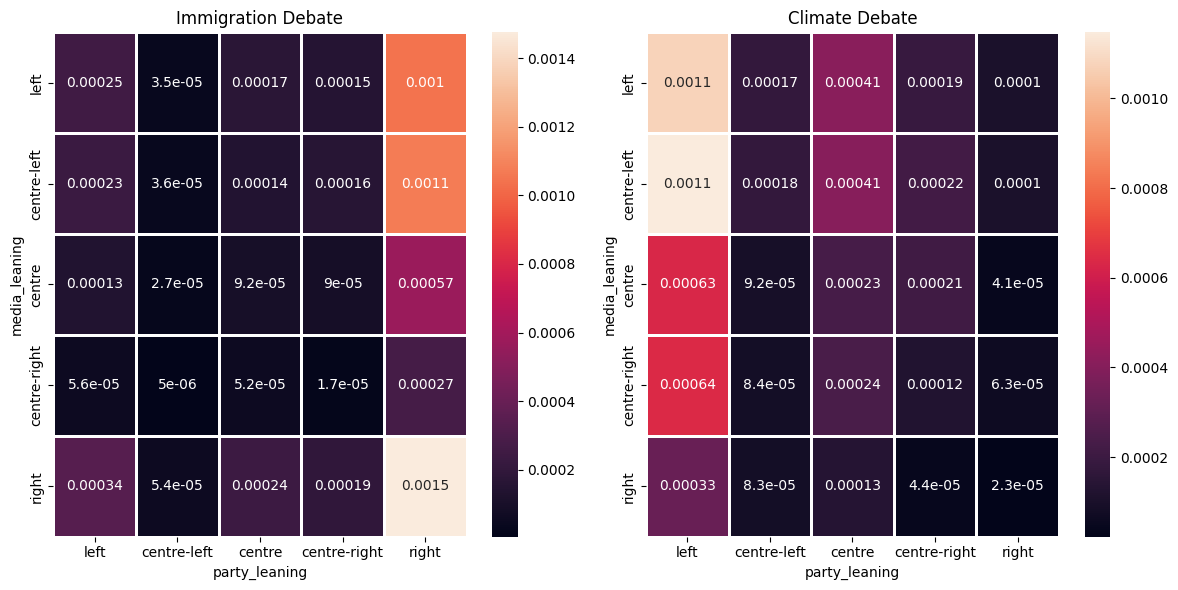

In [108]:
dataframes = [imm2017, clim2017]
names = ['immigration','climate']

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for df, name, ax in zip(dataframes, names, axes.flatten()):
    
    if name == 'immigration':
        plot = pd.crosstab(index=imm2017['media_leaning'], columns=imm2017['party_leaning'], values=imm2017['imm_alignment'], aggfunc='mean')
    
    if name == 'climate':
        plot = pd.crosstab(index=clim2017['media_leaning'], columns=clim2017['party_leaning'], values=clim2017['clim_alignment'], aggfunc='mean')
    
    sns.heatmap(plot, annot=True, ax=ax,linewidth=.8)
    ax.set_title(f'{name.capitalize()} Debate')
    
plt.tight_layout()
plt.show()

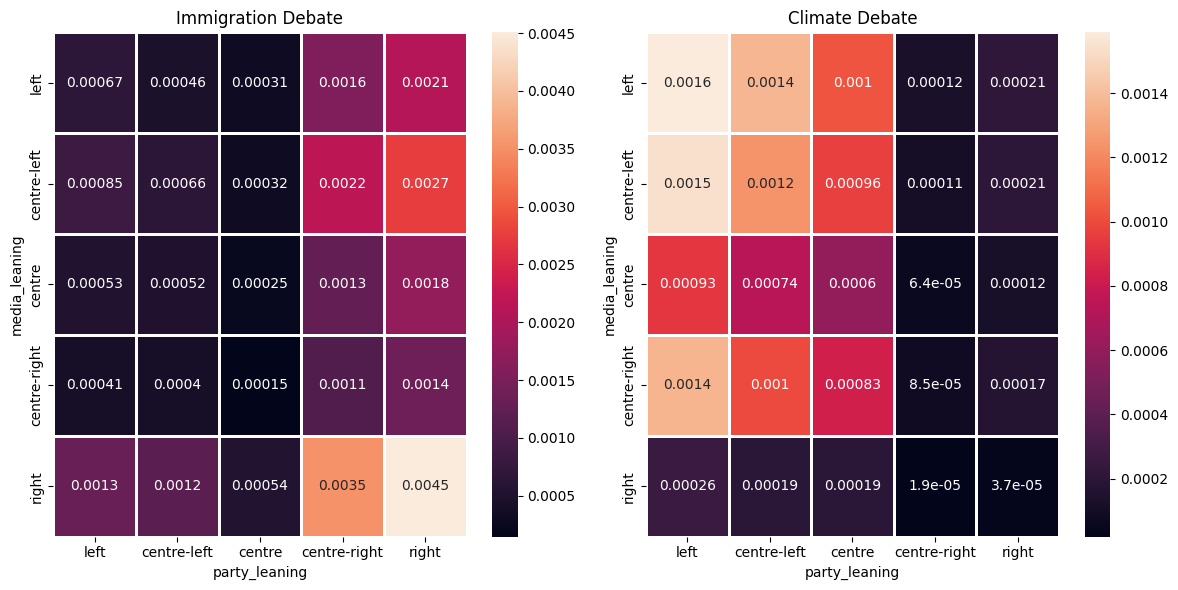

In [109]:
names = ['immigration','climate']

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for df, name, ax in zip(dataframes, names, axes.flatten()):
    
    if name == 'immigration':
        plot = pd.crosstab(index=imm2018['media_leaning'], columns=imm2018['party_leaning'], values=imm2018['imm_alignment'], aggfunc='mean')
    
    if name == 'climate':
        plot = pd.crosstab(index=clim2018['media_leaning'], columns=clim2018['party_leaning'], values=clim2018['clim_alignment'], aggfunc='mean')
    
    sns.heatmap(plot, annot=True, ax=ax,linewidth=.8)
    ax.set_title(f'{name.capitalize()} Debate')
    
plt.tight_layout()
plt.show()

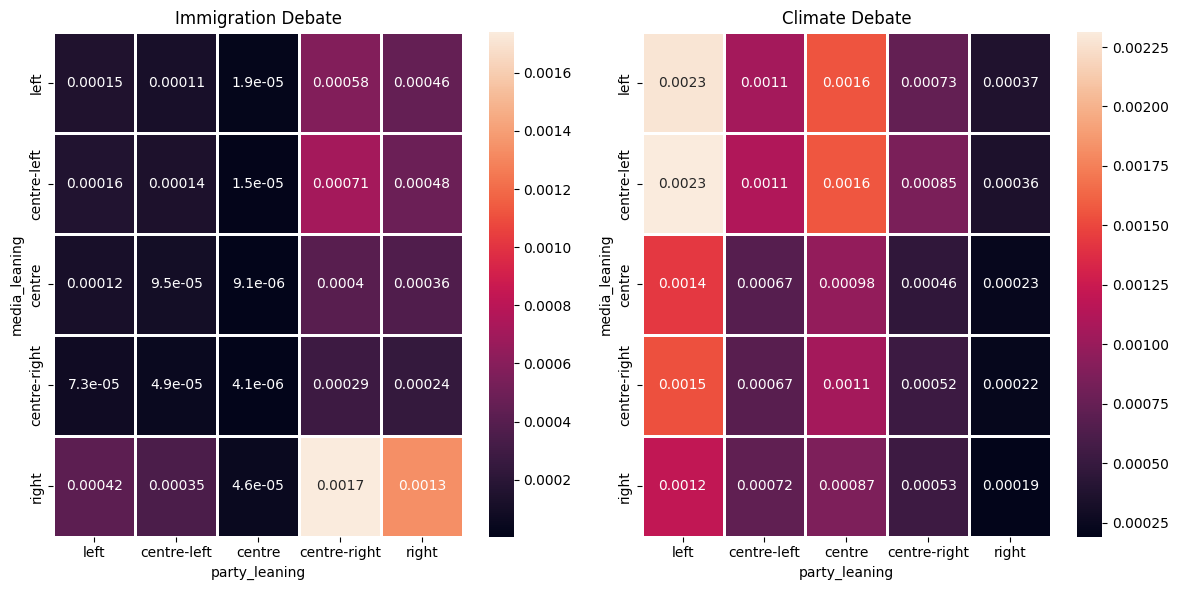

In [110]:
dataframes = [imm2017, clim2017]
names = ['immigration','climate']

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for df, name, ax in zip(dataframes, names, axes.flatten()):
    
    if name == 'immigration':
        plot = pd.crosstab(index=imm2019['media_leaning'], columns=imm2019['party_leaning'], values=imm2019['imm_alignment'], aggfunc='mean')
    
    if name == 'climate':
        plot = pd.crosstab(index=clim2019['media_leaning'], columns=clim2019['party_leaning'], values=clim2019['clim_alignment'], aggfunc='mean')
    
    sns.heatmap(plot, annot=True, ax=ax,linewidth=.8)
    ax.set_title(f'{name.capitalize()} Debate')
    
plt.tight_layout()
plt.show()

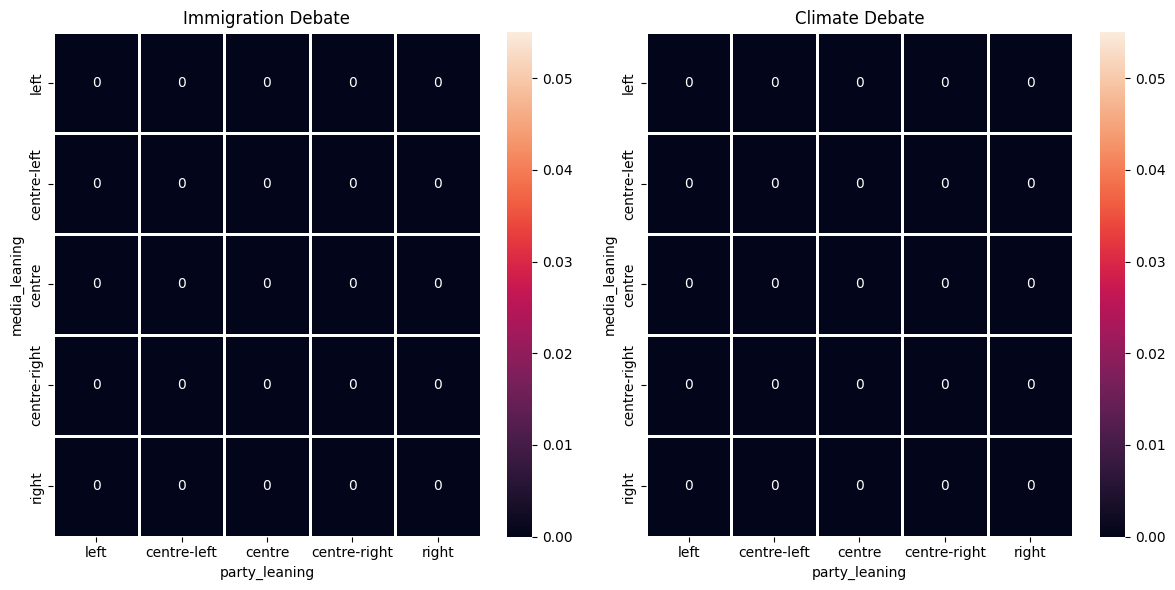

In [114]:
dataframes = [imm2017election, clim2017election]
names = ['immigration','climate']

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for df, name, ax in zip(dataframes, names, axes.flatten()):
    
    if name == 'immigration':
        plot = pd.crosstab(index=imm2017election['media_leaning'], columns=imm2017election['party_leaning'], values=imm2019['imm_alignment'], aggfunc='sum')
    
    if name == 'climate':
        plot = pd.crosstab(index=clim2017election['media_leaning'], columns=clim2017election['party_leaning'], values=clim2019['clim_alignment'], aggfunc='sum')
    
    sns.heatmap(plot, annot=True, ax=ax,linewidth=.8, vmin=min_val, vmax=max_val)
    ax.set_title(f'{name.capitalize()} Debate')
    
plt.tight_layout()
plt.show()

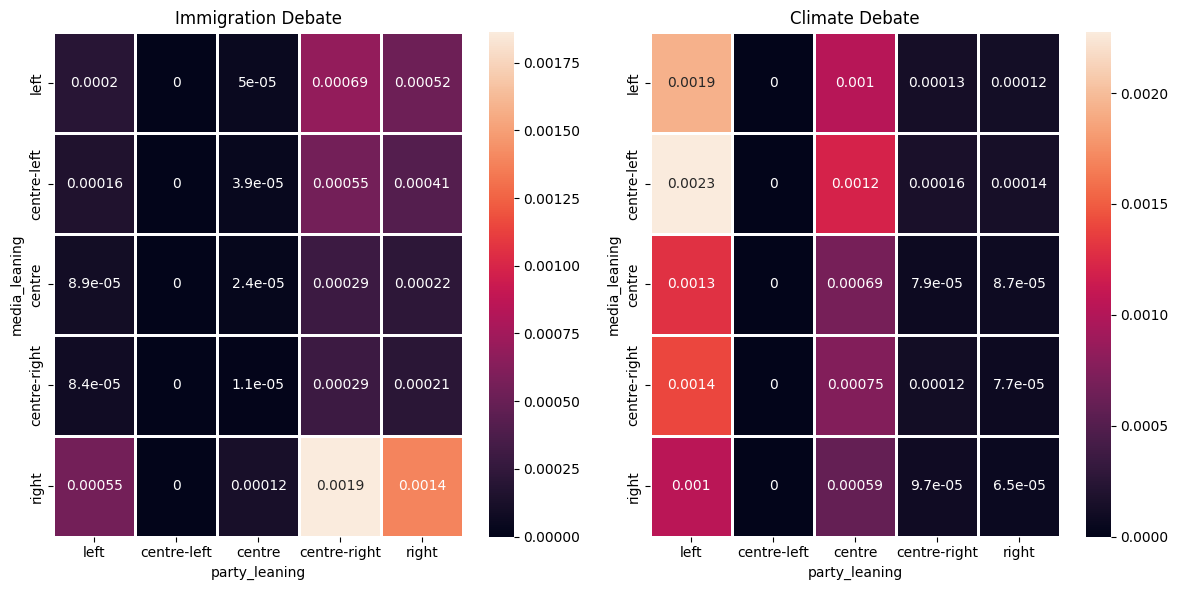

In [115]:
dataframes = [imm2019election, clim2019election]
names = ['immigration','climate']

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for df, name, ax in zip(dataframes, names, axes.flatten()):
    
    if name == 'immigration':
        plot = pd.crosstab(index=imm2019election['media_leaning'], columns=imm2019election['party_leaning'], values=imm2019['imm_alignment'], aggfunc='mean')
    
    if name == 'climate':
        plot = pd.crosstab(index=clim2019election['media_leaning'], columns=clim2019election['party_leaning'], values=clim2019['clim_alignment'], aggfunc='mean')
    
    sns.heatmap(plot, annot=True, ax=ax,linewidth=.8)
    ax.set_title(f'{name.capitalize()} Debate')
    
plt.tight_layout()
plt.show()

Explore evolution of alignment across all pairs of political leanings

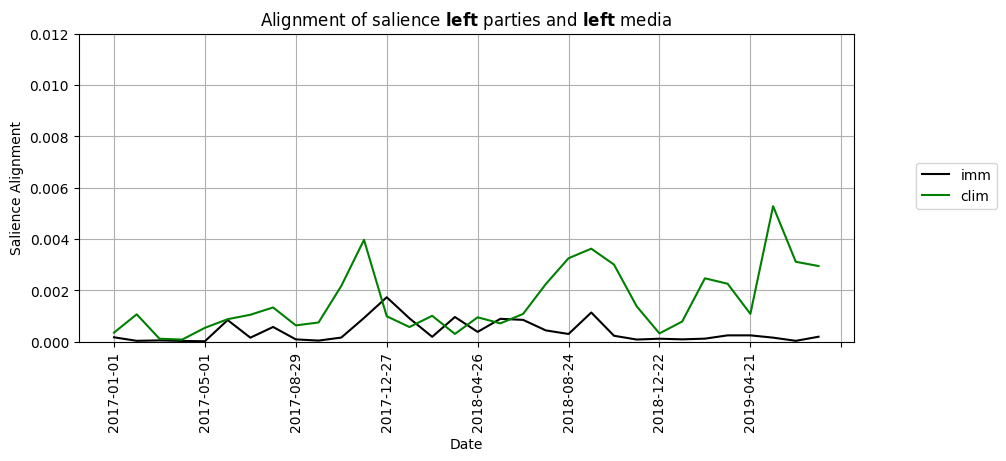

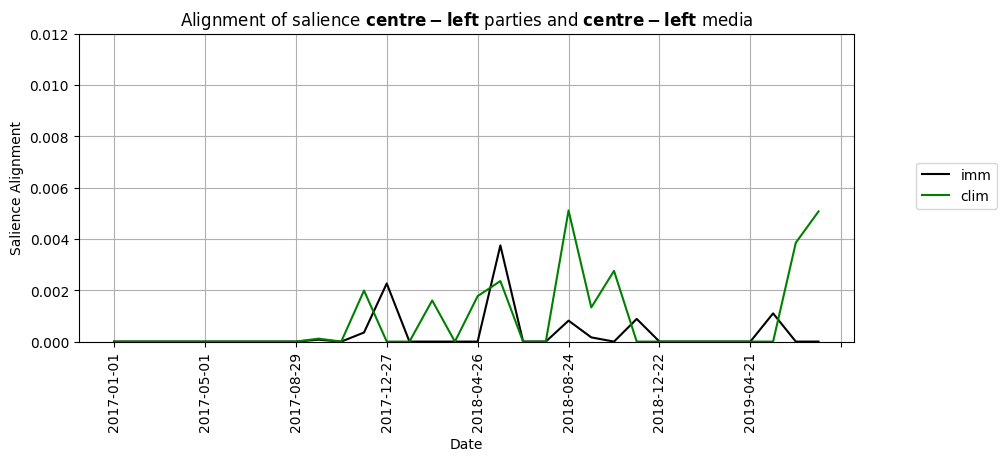

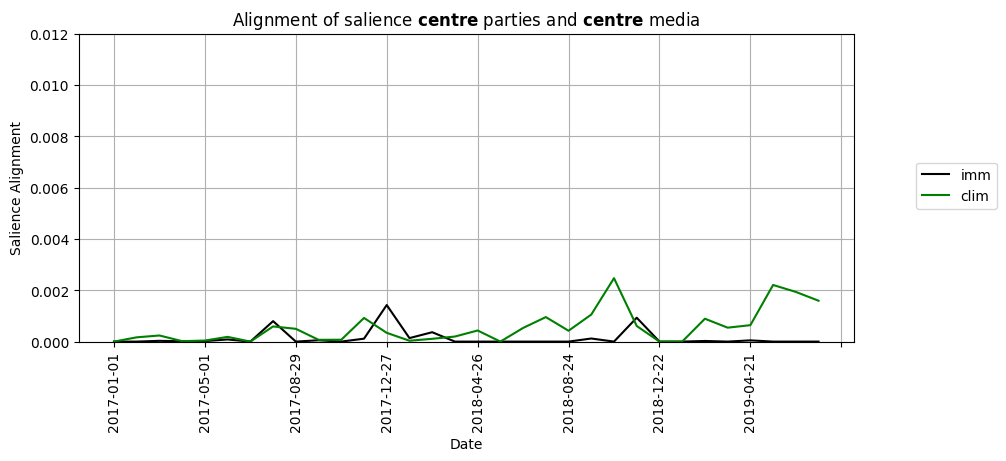

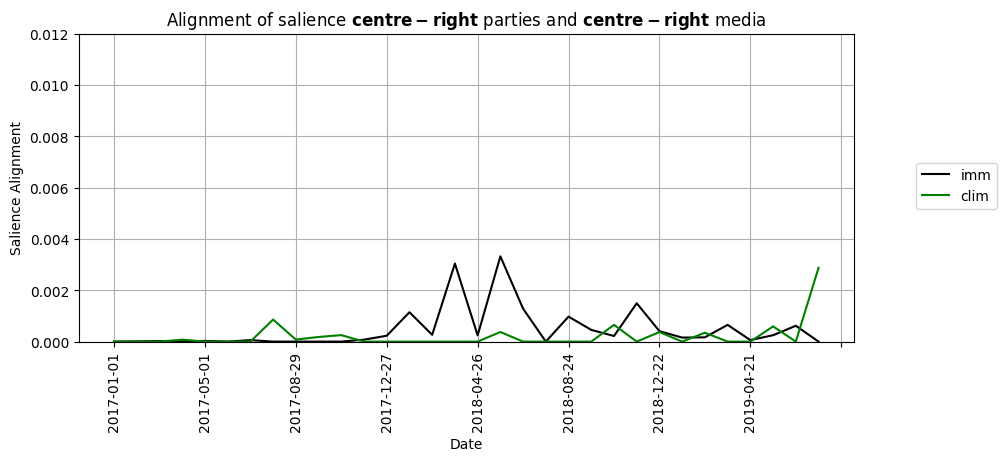

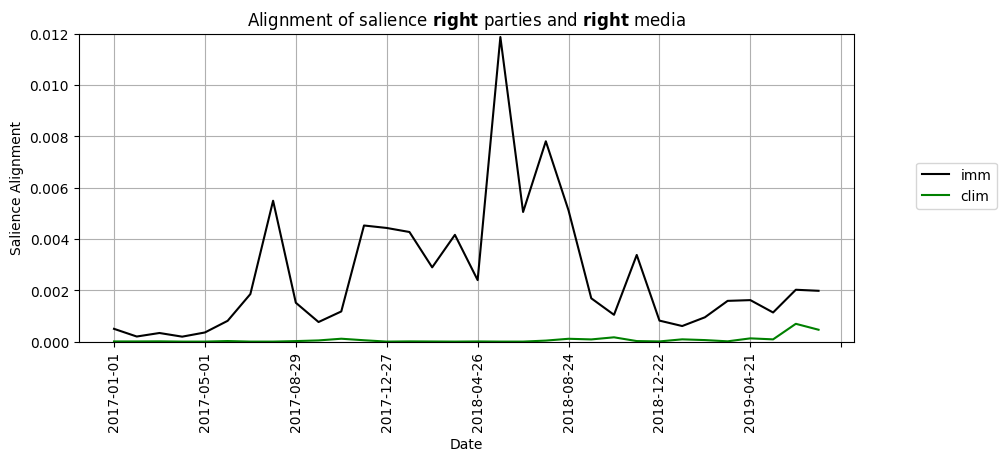

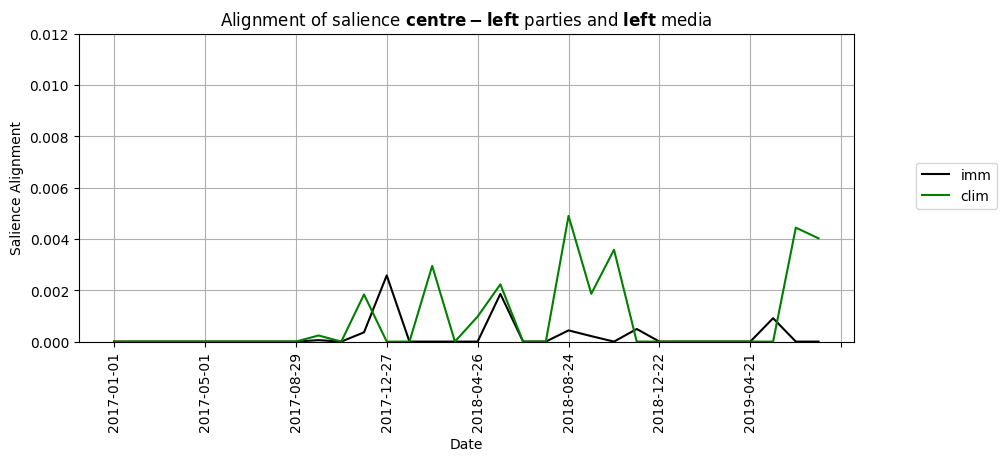

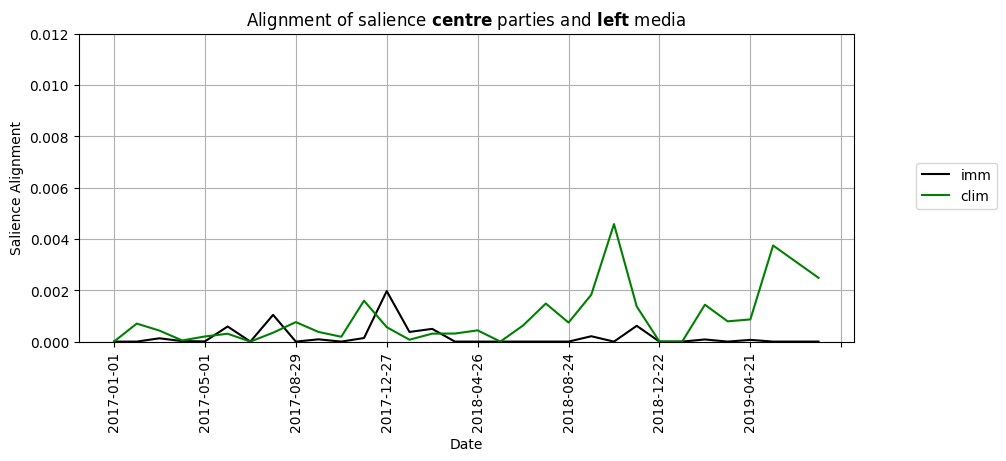

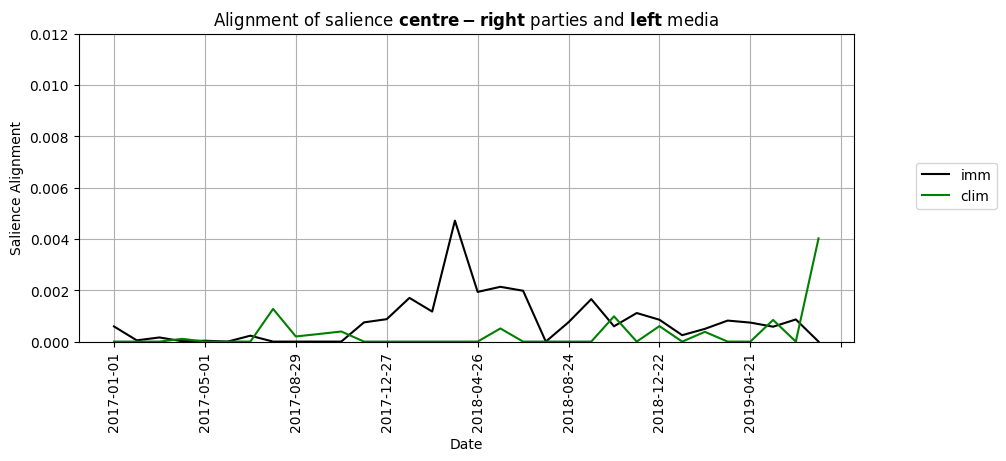

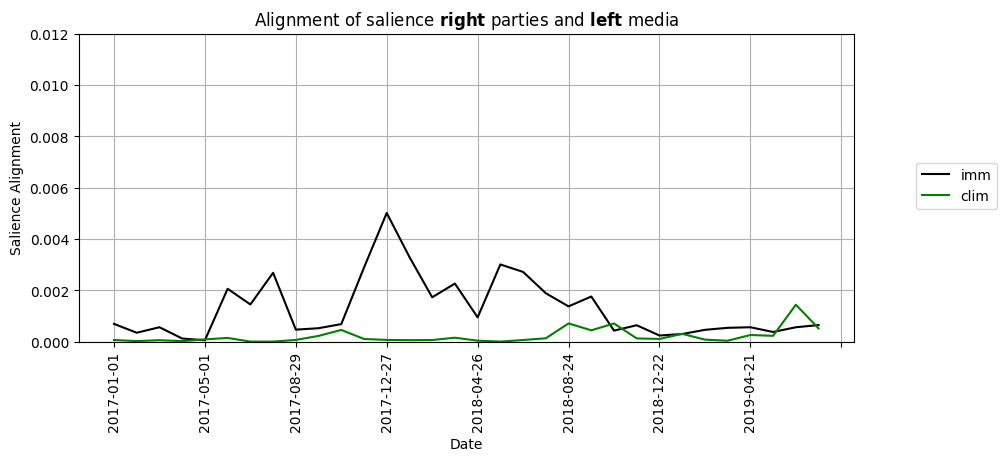

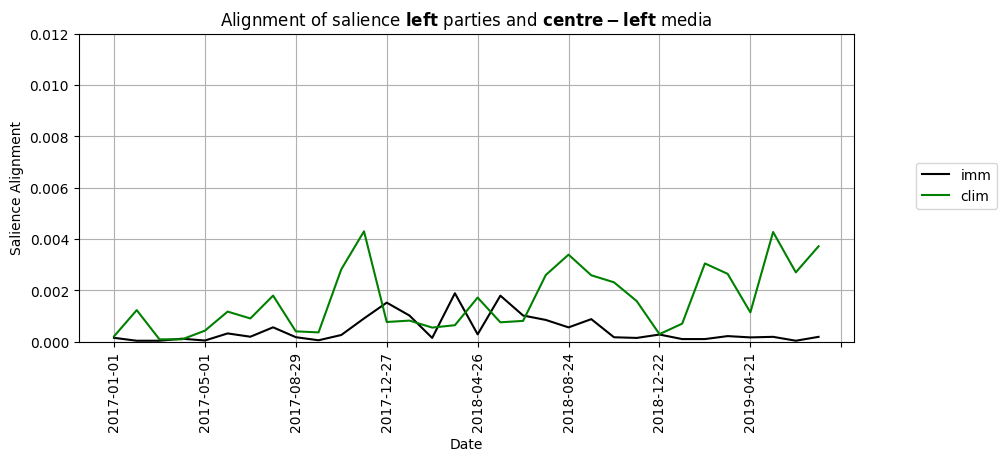

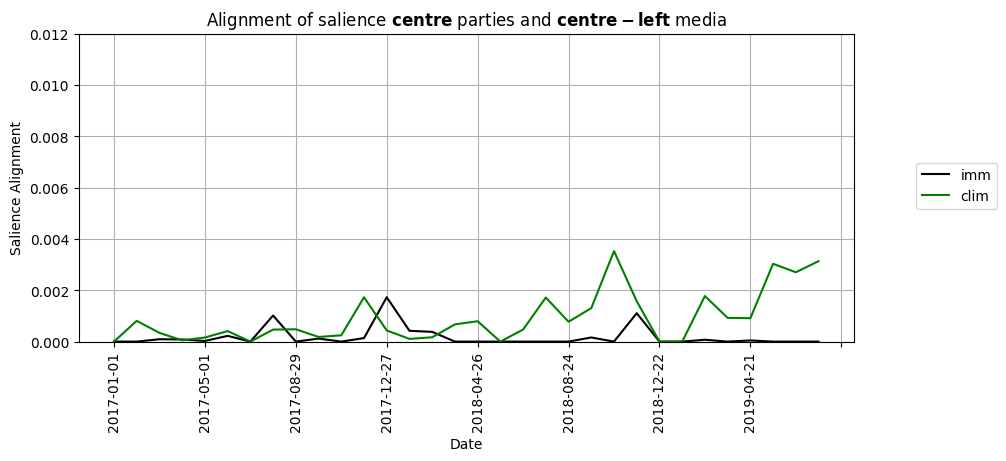

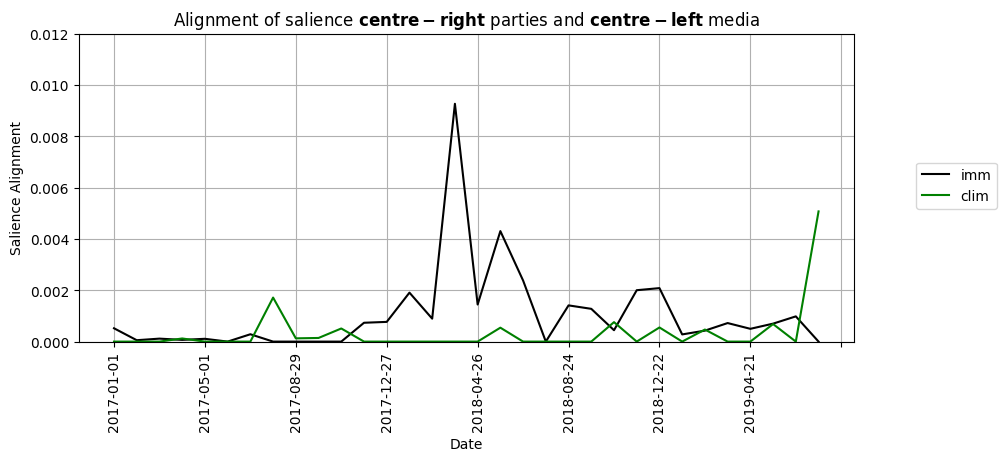

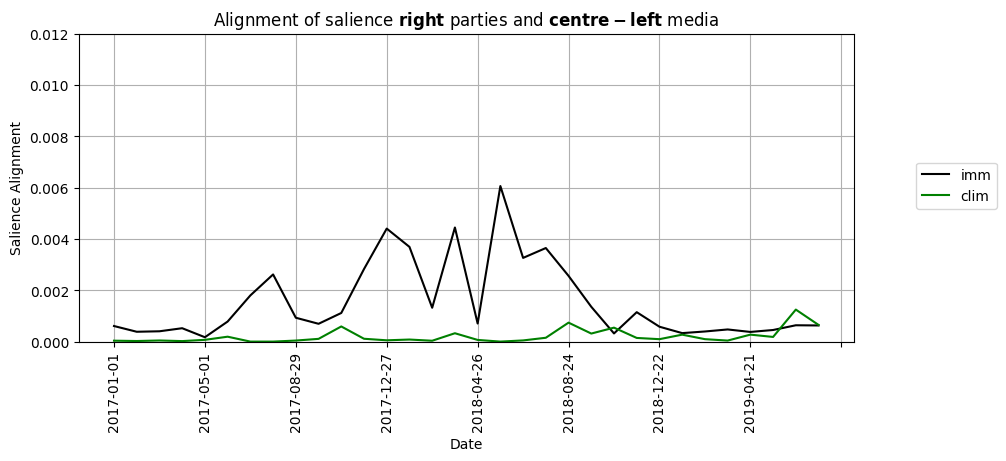

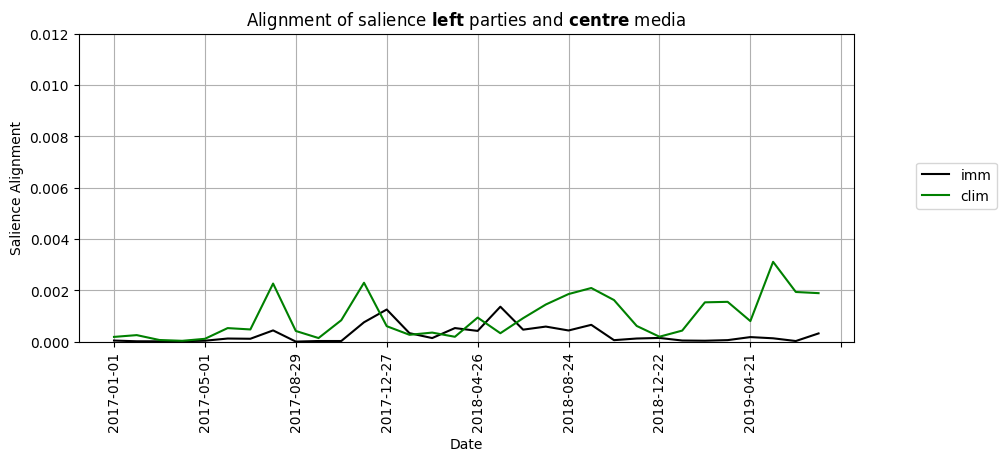

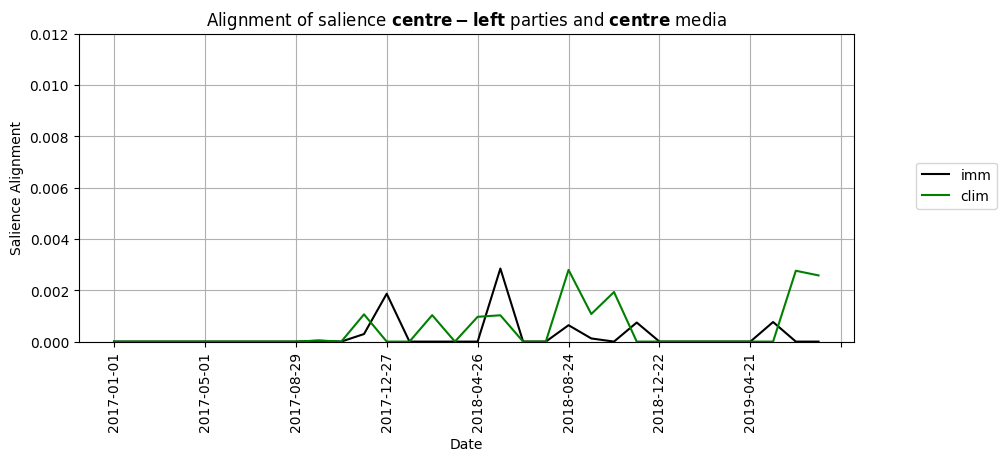

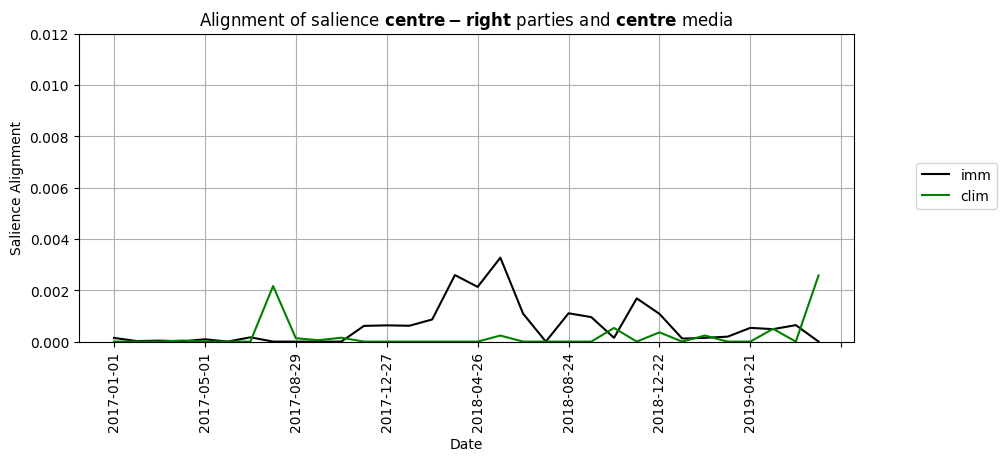

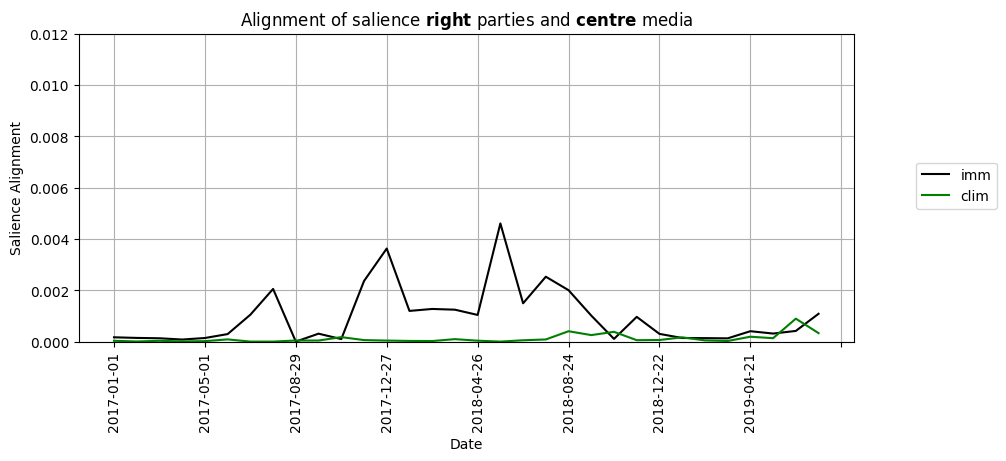

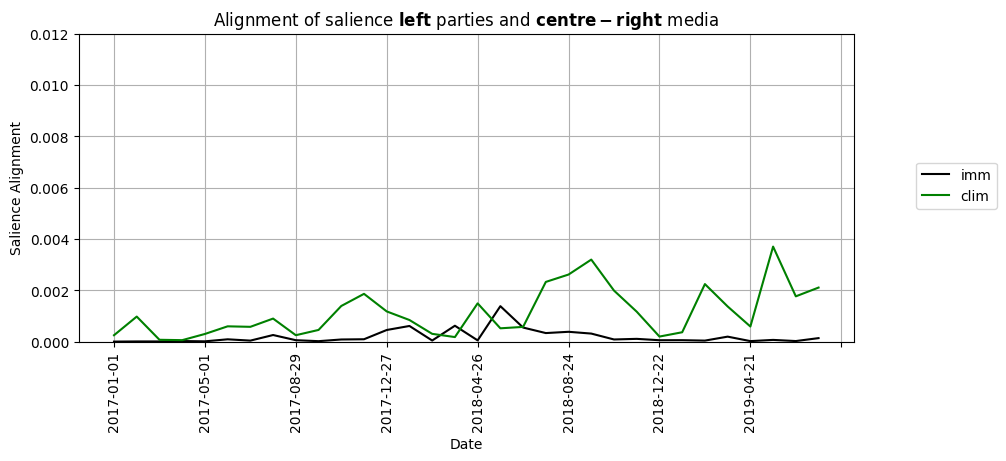

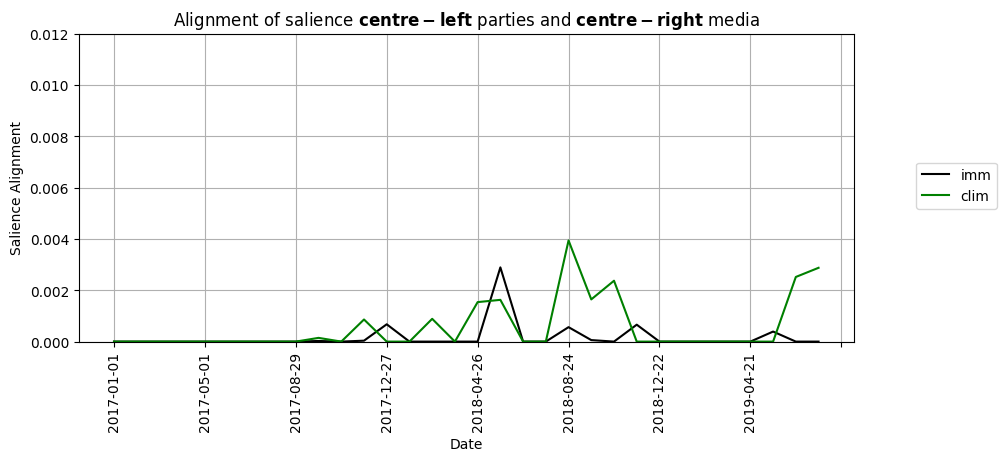

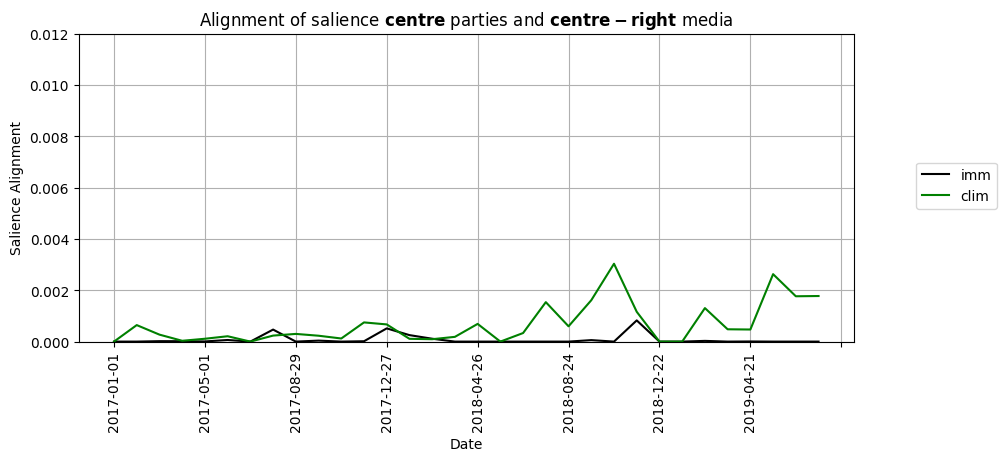

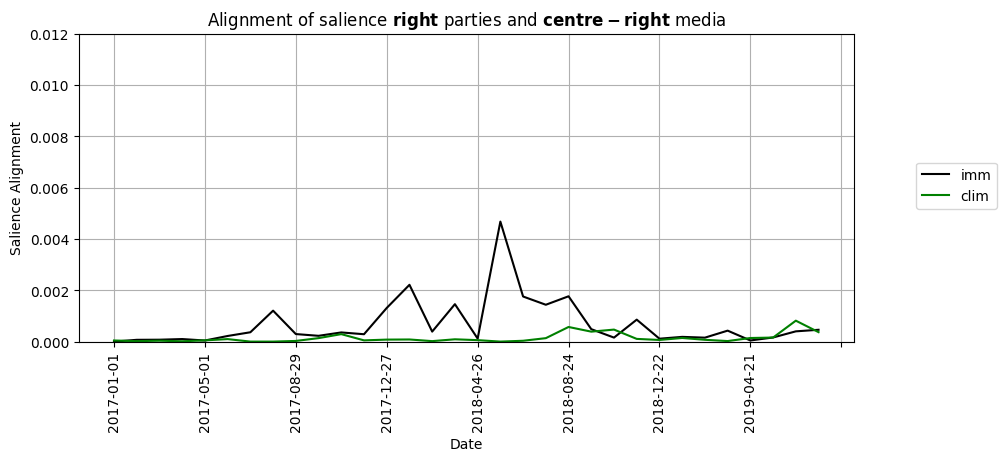

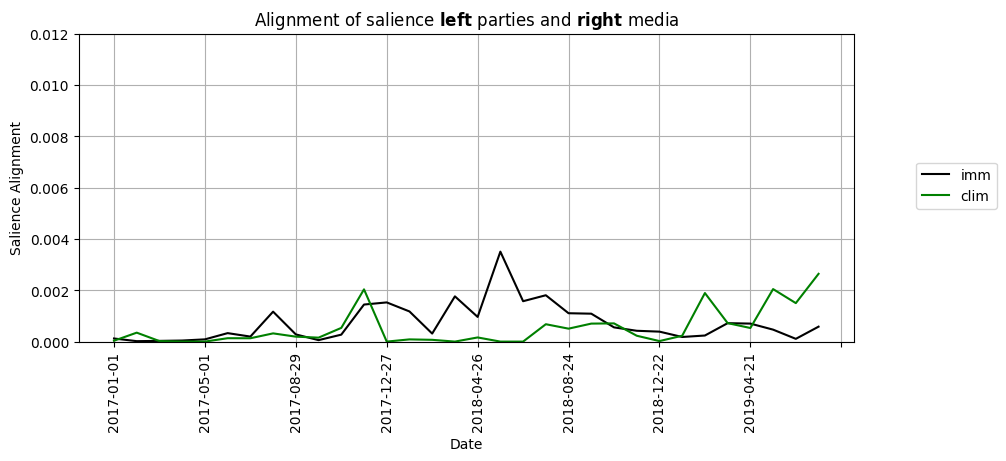

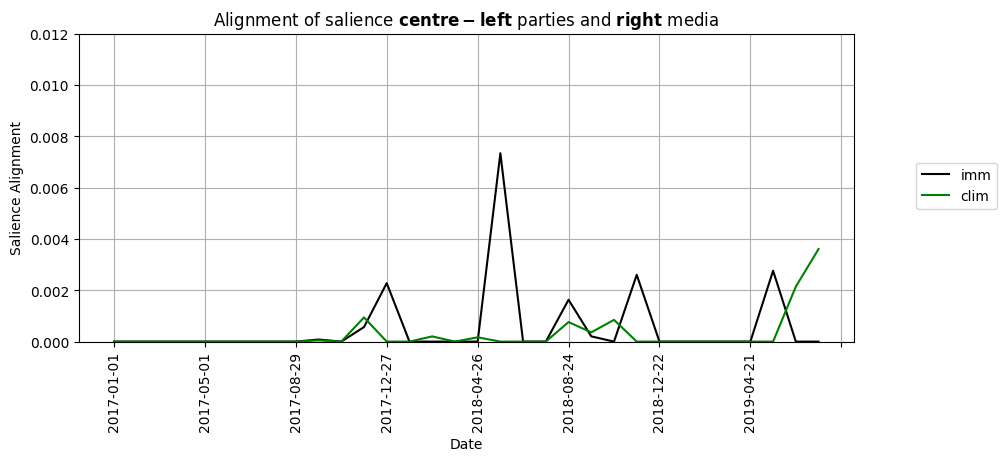

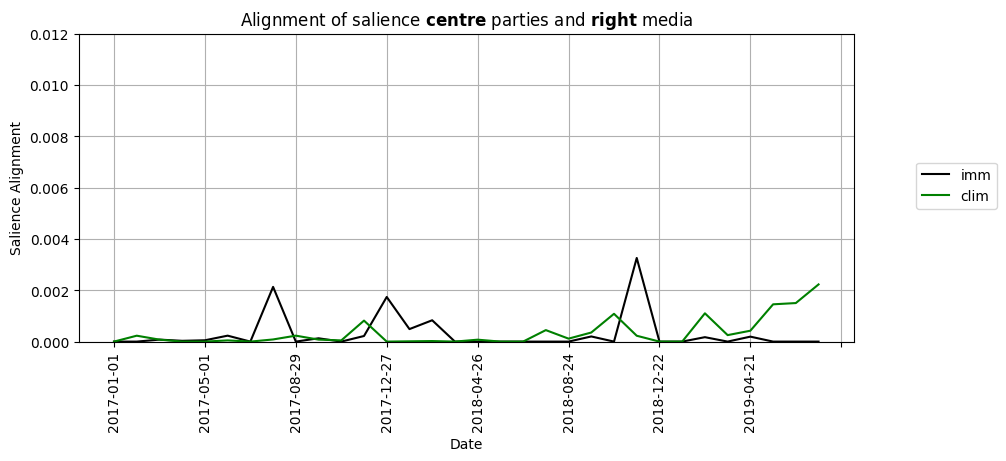

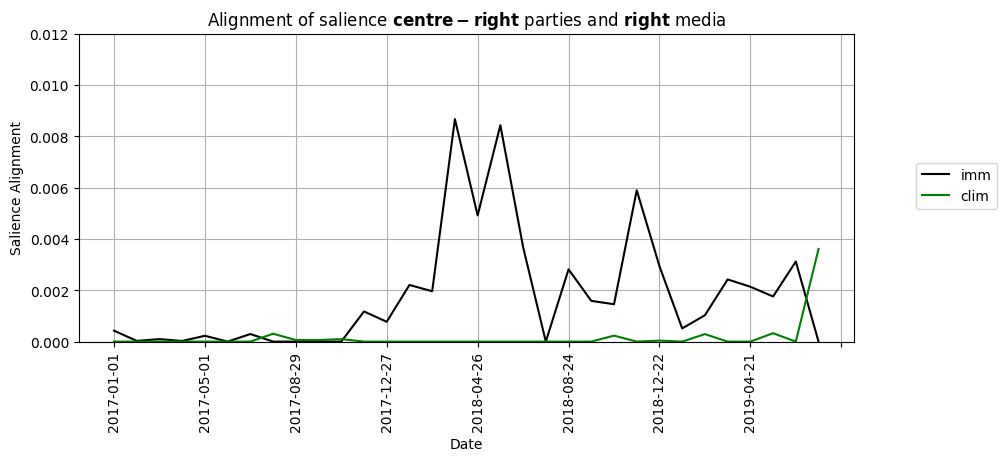

In [82]:
for pair in all_permutations:
    plot_alignment(plot_df,['imm','clim'], str(pair[0]), str(pair[1]))